# American Express - Default Prediction
## Predict if a customer will default in the future

### Competition Overview

Whether out at a restaurant or buying tickets to a concert, modern life counts on the convenience of a credit card to make daily purchases. It saves us from carrying large amounts of cash and also can advance a full purchase that can be paid over time. How do card issuers know we’ll pay back what we charge? That’s a complex problem with many existing solutions—and even more potential improvements, to be explored in this competition.

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

In this competition, you’ll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information. You're free to explore any technique to create the most powerful model, from creating features to using the data in a more organic way within a model.

If successful, you'll help create a better customer experience for cardholders by making it easier to be approved for a credit card. Top solutions could challenge the credit default prediction model used by the world's largest payment card issuer—earning you cash prizes, the opportunity to interview with American Express, and potentially a rewarding new career.

### Data Overview

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'S_2']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

### Objective

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

### Evaluation

The evaluation metric, M , for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient,G, and default rate captured at 4%,D.

M = 0.5(G + D)

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics G and D, the negative labels are given a weight of 20 to adjust for downsampling.

This metric has a maximum value of 1.0.

# Table of contents

* <a href="#C1">Part 1: Data import</a>
* <a href="#C2">Part 2: Data exploration</a>
    * <a href="#C3">Missing values</a>
    * <a href="#C4">Attention to customers</a>
    * <a href="#C5">Variables distribution</a>
* <a href="#C6">Part 3: Prediction models</a>
    * <a href="#C7">Data processing</a>
    * <a href="#C8">Model testing</a>
* <a href="#C9">Part 4: Final model</a>

# <a name="C1">Part 1: Data import</a>
We start by importing the useful libraries and datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import timeit
import pickle

from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option('display.max_columns', 100)

In [2]:
%%time
train = pd.read_feather('../input/amex-default-prediction-feather/train.feather')
test = pd.read_feather('../input/amex-default-prediction-feather/test.feather')
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
sample_submission = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
categorical_var = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'S_2']

CPU times: user 12 s, sys: 3.76 s, total: 15.8 s
Wall time: 20.5 s


In [19]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,...,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,...,0.669922,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,...,0.668457,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,NaN,NaN,0.007607,0.068848,0.720703,0.060486,0.003260,0.334717,0.524414,0.189453,NaN,0.066956,0.056641,0.005127,0.151978,1.336914,0.009354,0.007427,0.206665,0.738281,0.134033,NaN,0.048370,0.010078,0.000530,1.008789,0.006962,0.112244,0.136963,1.001953,0.304199,0.153809,0.114563,0.006329,0.139526,0.084778,0.056641,0.070618,0.305908,0.212158,...,0.670898,0.001264,0.019180,NaN,1.000977,2,NaN,0.004093,NaN,NaN,NaN,1.003906,0.154785,0.853516,0.003269,1,0.239868,0,4,0.240723,0.239746,0,0.705078,0.434326,0.003956,0.689941,0.009621,1,1.009766,1.007812,1.006836,0.003222,NaN,0.005680,0.005497,NaN,0.009224,0.009125,NaN,NaN,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,NaN,NaN,0.006405,0.055634,0.724121,0.166748,0.009918,0.323242,0.530762,0.135620,NaN,0.083740,0.049255,0.001417,0.151245,1.339844,0.006783,0.003515,0.208252,0.741699,0.134399,NaN,0.030060,0.009666,0.000783,1.007812,0.008705,0.102844,0.129028,0.704102,0.275146,0.155762,0.120728,0.004978,0.138062,0.048370,0.012497,0.065918,0.273438,0.204346,...,0.672852,0.002729,0.011719,NaN,1.004883,2,NaN,0.009705,NaN,NaN,NaN,1.002930,0.153931,0.844727,0.000053,1,0.240967,0,4,0.239380,0.240723,0,0.711426,0.437012,0.005135,0.687988,0.004650,1,1.001953,1.003906,1.007812,0.007702,NaN,0.007107,0.008263,NaN,0.007206,0.002409,NaN,NaN,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,NaN,NaN,0.007732,0.038849,0.720703,0.143677,0.006

In [22]:
print("train data shape:", train.shape)
print("test data shape:", test.shape)
print("train lablels shape:", train_labels.shape)

train data shape: (5531451, 190)
test data shape: (11363762, 190)
train lablels shape: (458913, 2)


# <a name="C2">Part 2: Data exploration</a>

## <a name="C3">2.1: Missing values</a>
Let's first have a look at missing values.

In [23]:
def quantity_missing_values(data):
    """function to obtain the number and percentage of missing values for each variable of a dataframe, 
    in descending order"""
    
    values = data.isnull().sum()
    percentage = 100 * values / len(data)
    table = pd.concat([values, percentage.round(2)], axis=1)
    table.columns = ['Number of missing values', '% of missing values']
    
    return table[table['Number of missing values'] != 0].sort_values('% of missing values', ascending = False).style.background_gradient('OrRd')

In [24]:
quantity_missing_values(train)

,Number of missing values,% of missing values
D_87,5527586,99.930000
D_88,5525447,99.890000
D_108,5502513,99.480000
D_110,5500117,99.430000
D_111,5500117,99.430000
B_39,5497819,99.390000
D_73,5475595,98.990000
B_42,5459973,98.710000
D_135,5336752,96.480000
D_138,5336752,96.480000


It appears that for some variables, a lot of data is missing. But it should be kept in mind that cases of fraud or non-payment are quite rare, hence a high number of missing values. We will consider that the dataset does not contain any error and keep the missing values for the moment.

## <a name="C4">2.2: Attention to customers</a>
Let's now have a look at the number of customers and how many times they appear in the dataset.

In [25]:
nb_customers = len(list(train['customer_ID'].unique()))
print("Number of customers:", nb_customers)

Number of customers: 458913


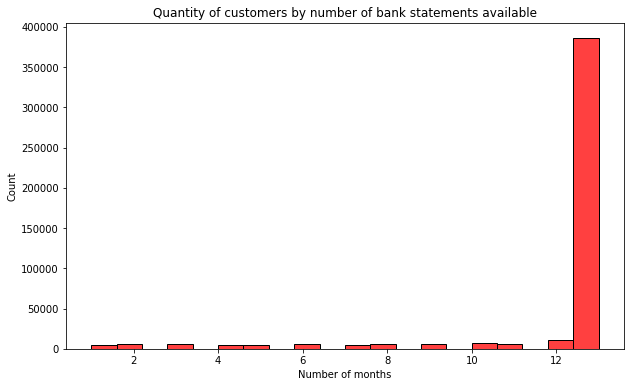

In [26]:
y = train.groupby("customer_ID")['customer_ID'].count().values

plt.figure(figsize=(10, 6))
sns.histplot(data=y, color='red')
plt.xlabel('Number of months')
plt.title('Quantity of customers by number of bank statements available')
plt.show()

For most customers, we have the bank statements of the last 13 months.</br>
Let's now have a look at the quantity of customers with default payment.

In [27]:
# connection between the number of bank statements and the target output
df = train.groupby("customer_ID")['customer_ID'].count()
df = pd.DataFrame({"customer_ID":df.index, "count": df.values})
# merge the data with the label data frame
df = df.merge(train_labels, on='customer_ID', how='left')

df.head()

,customer_ID,count,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,0


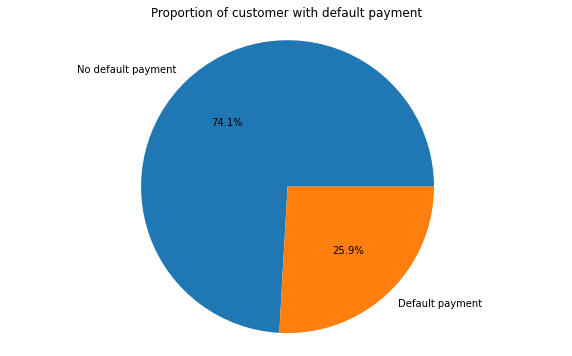

In [28]:
labels = ['No default payment', 'Default payment']

plt.figure(figsize=(10, 6))
plt.pie(df['target'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of customer with default payment')
plt.show()

A quarter of customers did not pay back their credit card balance amount. It's way more than what we expected, but this proportion may not be representative of the reality. More clients with payment defaults could have been added in order to produce more accurate models in the future. 

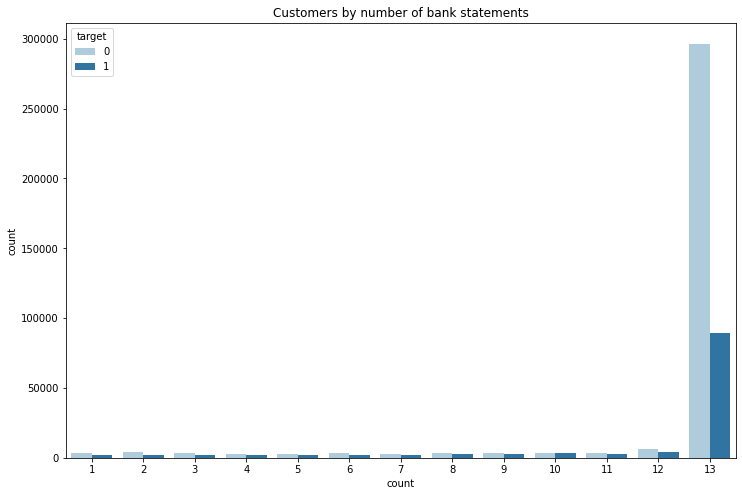

In [29]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='count',hue='target', palette='Paired')
plt.title('Customers by number of bank statements')
plt.show()

## <a name="C5">2.3: Variables distribution</a>

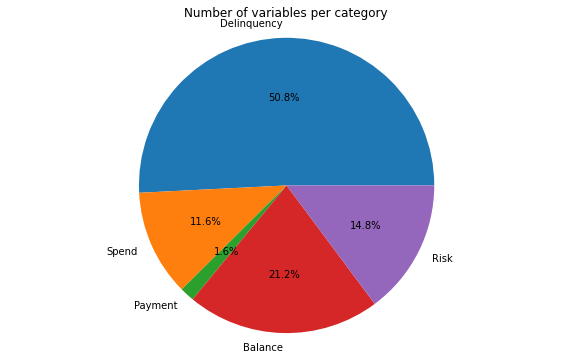

In [3]:
#Number of variables per category
D_features = [c for c in train.columns if c.startswith('D_')]
S_features = [c for c in train.columns if c.startswith('S_')]
P_features = [c for c in train.columns if c.startswith('P_')]
B_features = [c for c in train.columns if c.startswith('B_')]
R_features = [c for c in train.columns if c.startswith('R_')]

nb_features = [len(D_features) ,len(S_features), len(P_features), len(B_features),
              len(R_features)]
labels = ['Delinquency', 'Spend', 'Payment', 'Balance', 'Risk']

plt.figure(figsize=(10, 6))
plt.pie(nb_features, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Number of variables per category')
plt.show()

Principal variables are related to delinquency, which are also the ones containing the most missing values. But as mentioned before, delinquency does not concern erverybody (fortunately !).

In [4]:
data = train.merge(train_labels, on='customer_ID', how='left')
data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,...,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,...,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,...,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,NaN,NaN,0.007607,0.068848,0.720703,0.060486,0.003260,0.334717,0.524414,0.189453,NaN,0.066956,0.056641,0.005127,0.151978,1.336914,0.009354,0.007427,0.206665,0.738281,0.134033,NaN,0.048370,0.010078,0.000530,1.008789,0.006962,0.112244,0.136963,1.001953,0.304199,0.153809,0.114563,0.006329,0.139526,0.084778,0.056641,0.070618,0.305908,0.212158,...,0.001264,0.019180,NaN,1.000977,2,NaN,0.004093,NaN,NaN,NaN,1.003906,0.154785,0.853516,0.003269,1,0.239868,0,4,0.240723,0.239746,0,0.705078,0.434326,0.003956,0.689941,0.009621,1,1.009766,1.007812,1.006836,0.003222,NaN,0.005680,0.005497,NaN,0.009224,0.009125,NaN,NaN,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,NaN,NaN,0.006405,0.055634,0.724121,0.166748,0.009918,0.323242,0.530762,0.135620,NaN,0.083740,0.049255,0.001417,0.151245,1.339844,0.006783,0.003515,0.208252,0.741699,0.134399,NaN,0.030060,0.009666,0.000783,1.007812,0.008705,0.102844,0.129028,0.704102,0.275146,0.155762,0.120728,0.004978,0.138062,0.048370,0.012497,0.065918,0.273438,0.204346,...,0.002729,0.011719,NaN,1.004883,2,NaN,0.009705,NaN,NaN,NaN,1.002930,0.153931,0.844727,0.000053,1,0.240967,0,4,0.239380,0.240723,0,0.711426,0.437012,0.005135,0.687988,0.004650,1,1.001953,1.003906,1.007812,0.007702,NaN,0.007107,0.008263,NaN,0.007206,0.002409,NaN,NaN,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,NaN,NaN,0.007732,0.038849,0.720703,0.143677,0.006668,0.230957,0.529297,NaN,N

In [5]:
def plot_histogram(data, columns, nrow, ncol, figsize, title, hue=None):
    """Display function of input variables"""
    
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    col, row = ncol, nrow
    cpt = 0
    for r in range(row):
        for c in range(col):
            if cpt < len(columns):
                if nrow > 1:
                    sns.kdeplot(data=data, x=columns[cpt], hue=hue, ax=ax[r, c], palette=["#FFA384","#74BDCB"], fill=True, 
                                hue_order=[1,0], legend=True)
                    ax[r,c].set(xlabel = columns[cpt], ylabel=("Density"))
                else:
                    sns.kdeplot(data=data, x=columns[cpt], hue=hue, ax=ax[c], palette=["#FFA384","#74BDCB"], fill=True, 
                                hue_order=[1,0], legend=True)
                    ax[c].set(xlabel = columns[cpt], ylabel=("Density"))
            cpt +=1
    fig.suptitle(title)
    plt.show()

In [5]:
def plot_correlation_matrix(data, figsize, title):
    """Display function of the correlation matrix of input variables"""
    plt.figure(figsize=figsize)
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype = bool))
    sns.heatmap(corr, annot=True, cmap='YlGnBu', mask=mask, fmt='.1f', linewidths=.5, square=True, vmax=1)
    plt.title(title)
    plt.show()

We can have a quick look at the distribution of numerical variables, but we must not forget that data is already normalized and we won't have the true distributions. It'll be probably more interesting to have a look at correlations between varibales.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


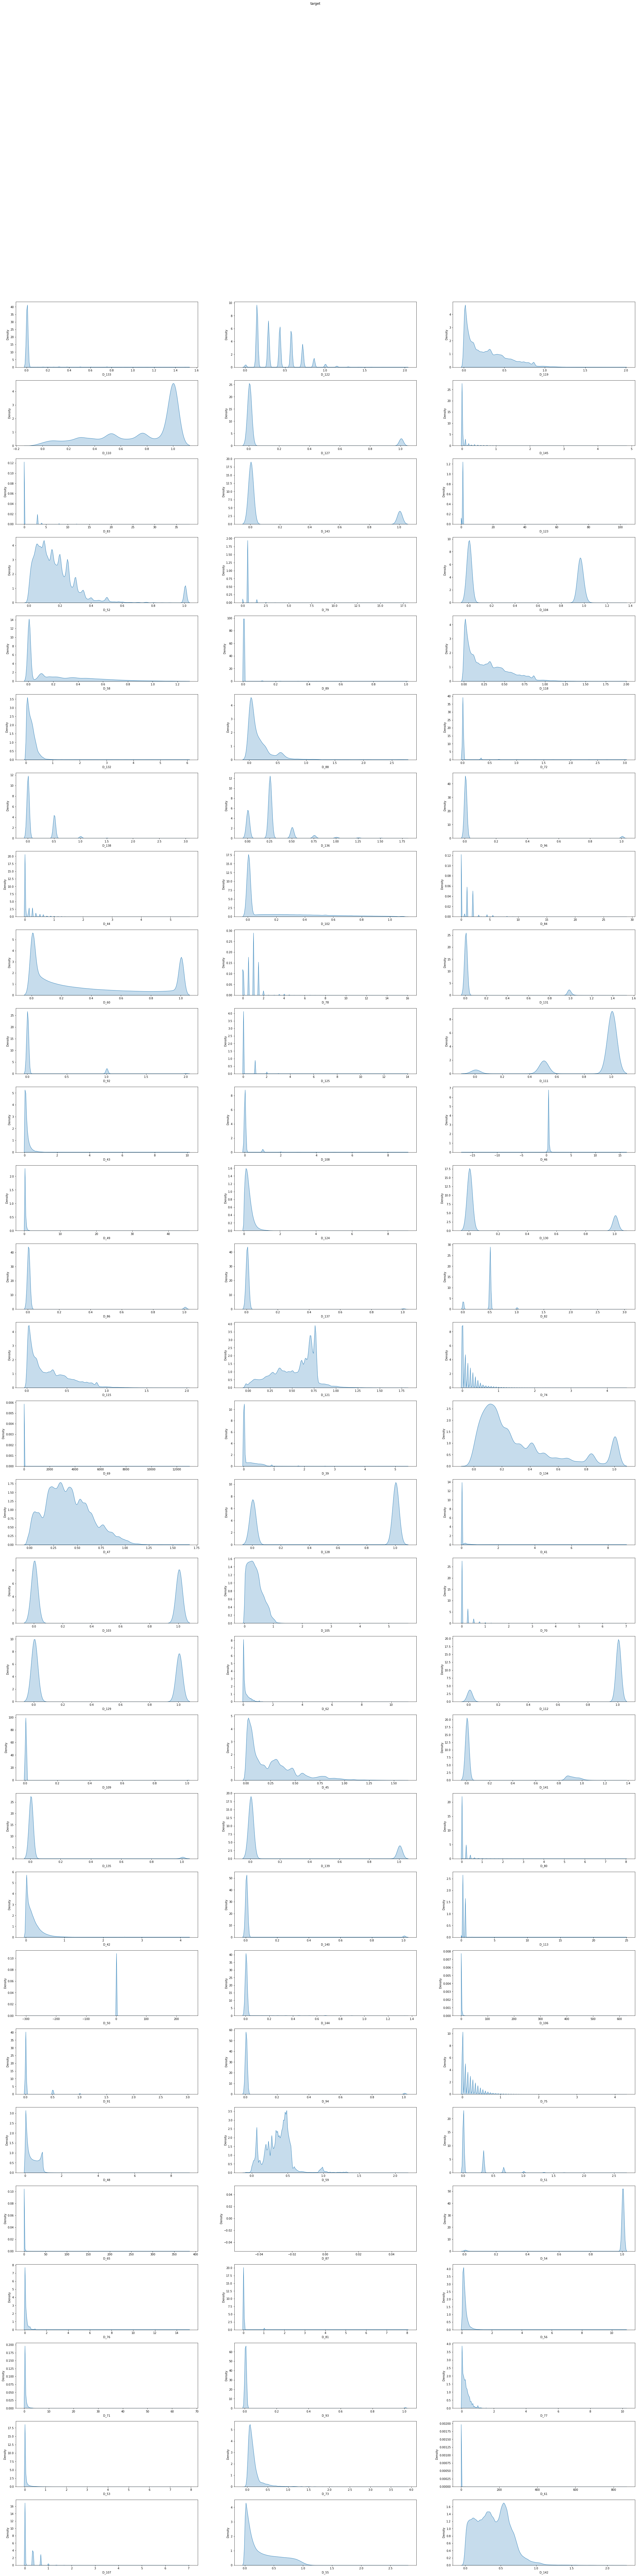

In [8]:
D_cat_features = list(set(D_features)-set(categorical_var))
nrow = 29
ncol = 3
figsize = (40, 150)
hue = 'target'
title = 'Spend variables distributions'

plot_histogram(data, D_cat_features, nrow, ncol, figsize, hue)

In [ ]:
plot_correlation_matrix(data[D_cat_features], (11, 11), 'Correlation of Delinquency variables')

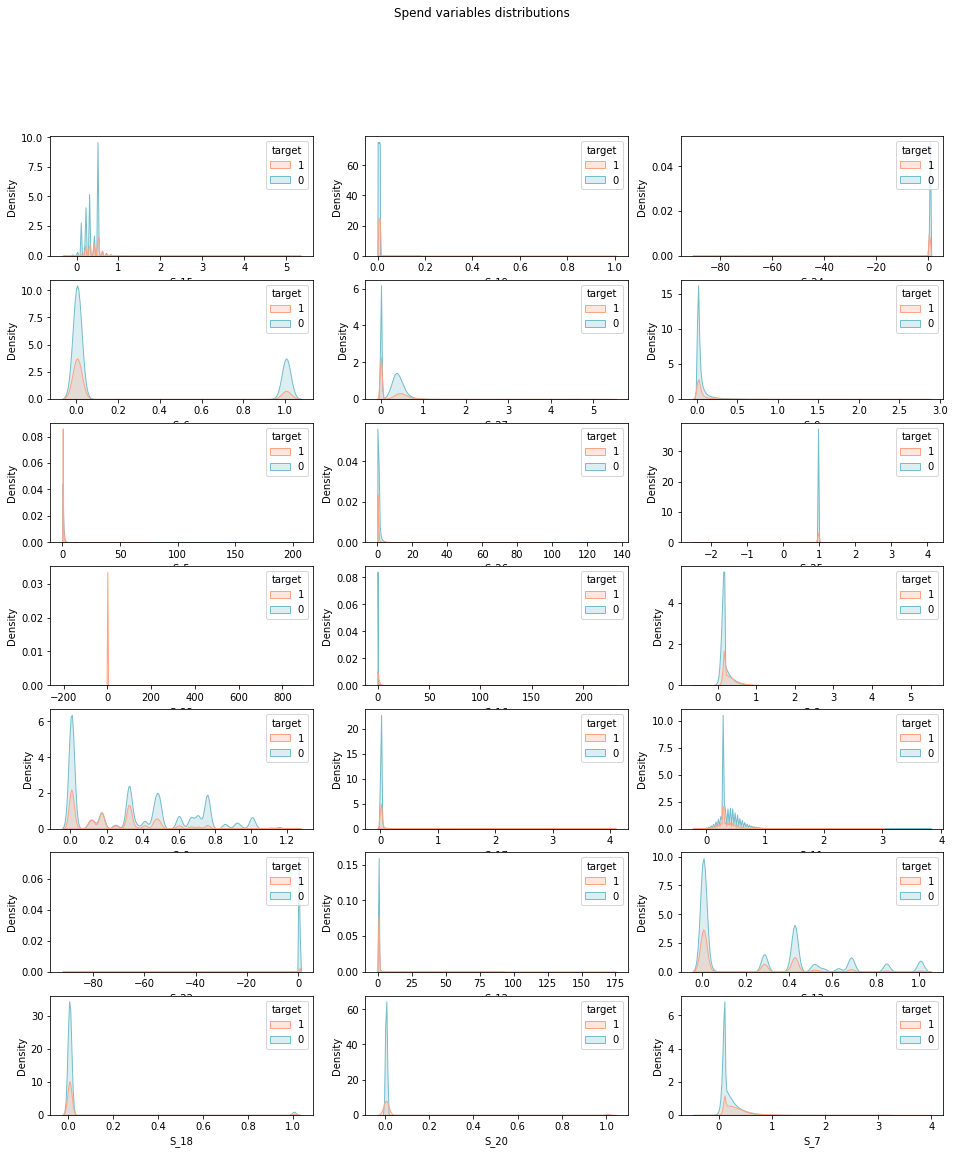

In [35]:
S_cat_features = list(set(S_features)-set(categorical_var))
nrow = 7
ncol = 3
figsize = (16, 18)
hue = 'target'
title = 'Spend variables distributions'

plot_histogram(data, S_cat_features, nrow, ncol, figsize, title, hue)

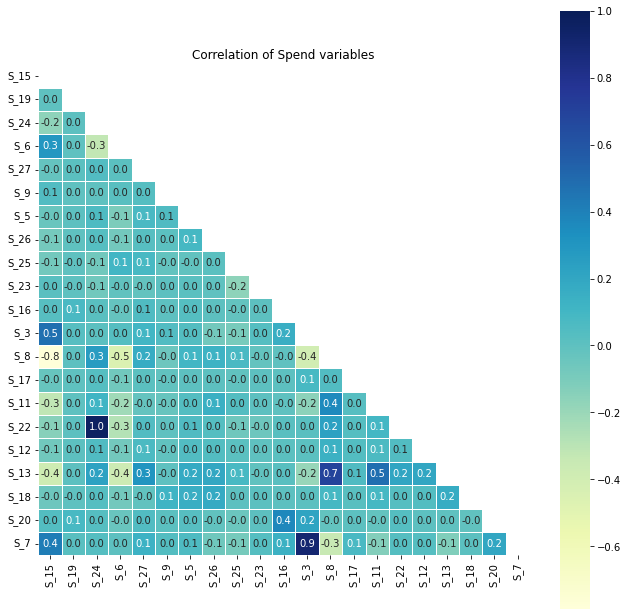

In [37]:
plot_correlation_matrix(data[S_cat_features], (11, 11), 'Correlation of Spend variables')

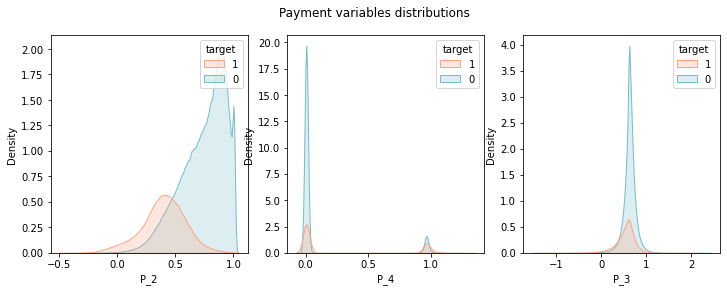

In [15]:
P_cat_features = list(set(P_features)-set(categorical_var))
nrow = 1
ncol = 3
figsize = (12, 4)
hue = 'target'
title = 'Payment variables distributions'

plot_histogram(data, P_cat_features, nrow, ncol, figsize, title, hue)

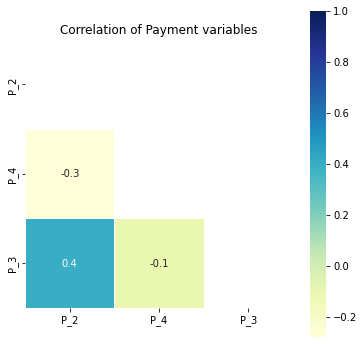

In [16]:
plot_correlation_matrix(data[P_cat_features], (6, 6), 'Correlation of Payment variables')

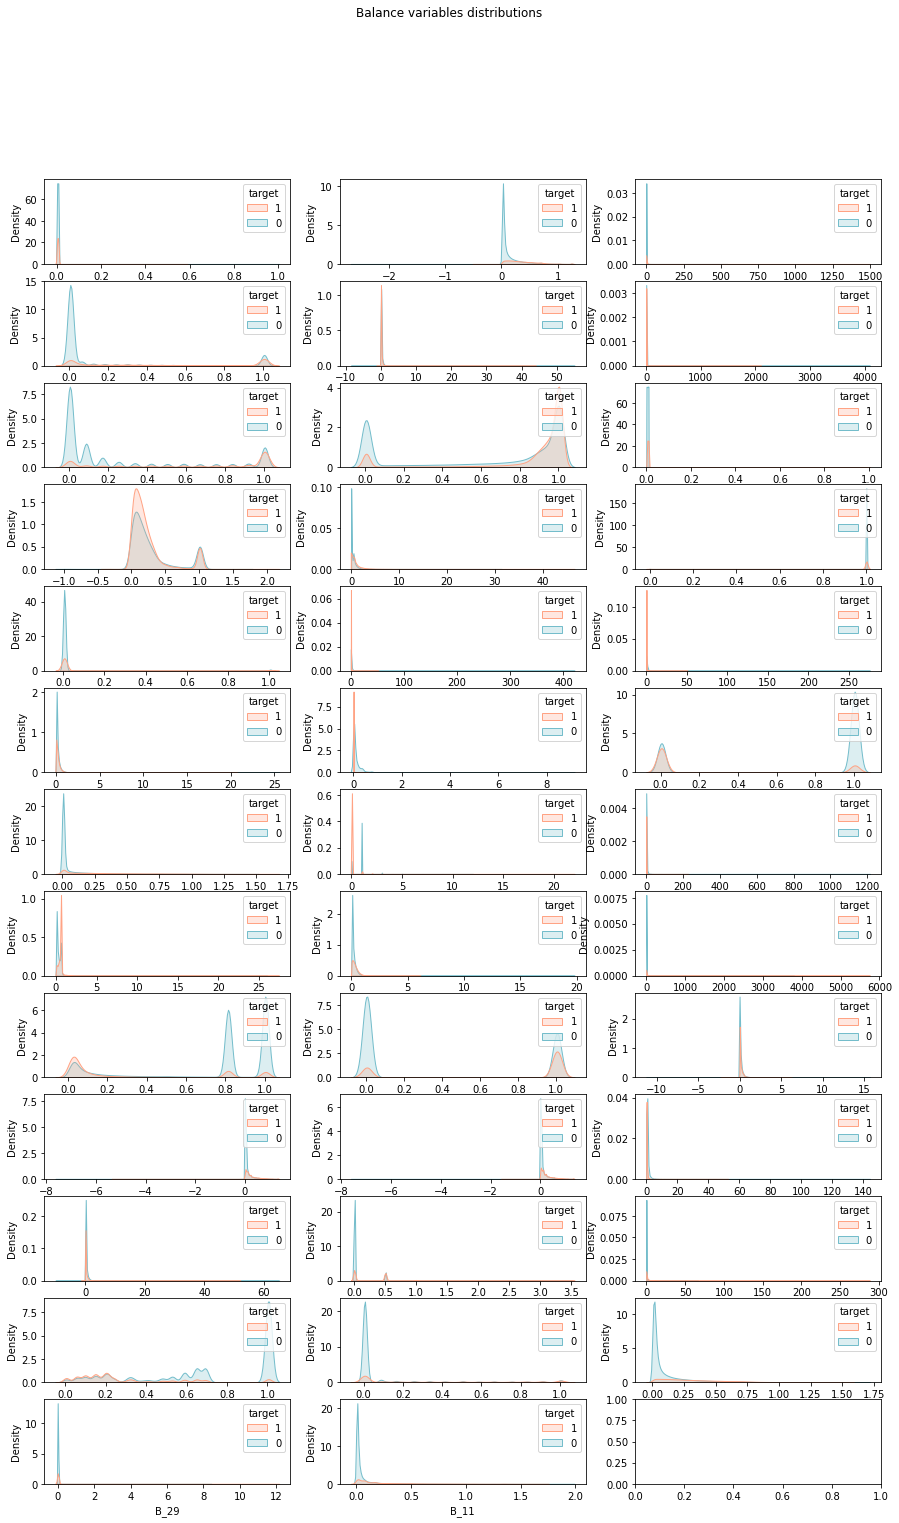

In [12]:
B_cat_features = list(set(B_features)-set(categorical_var))
nrow = 13
ncol = 3
figsize = (15, 24)
hue = 'target'
title = 'Balance variables distributions'

plot_histogram(data, B_cat_features, nrow, ncol, figsize, title, hue)

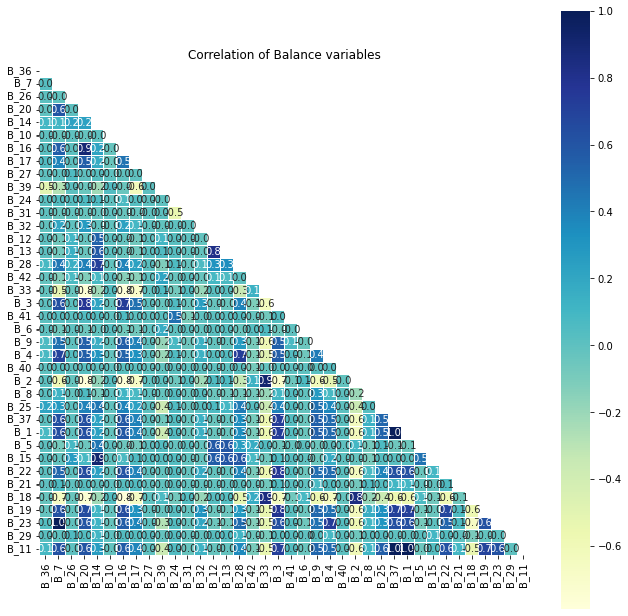

In [13]:
plot_correlation_matrix(data[B_cat_features], (11, 11), 'Correlation of Balance variables')

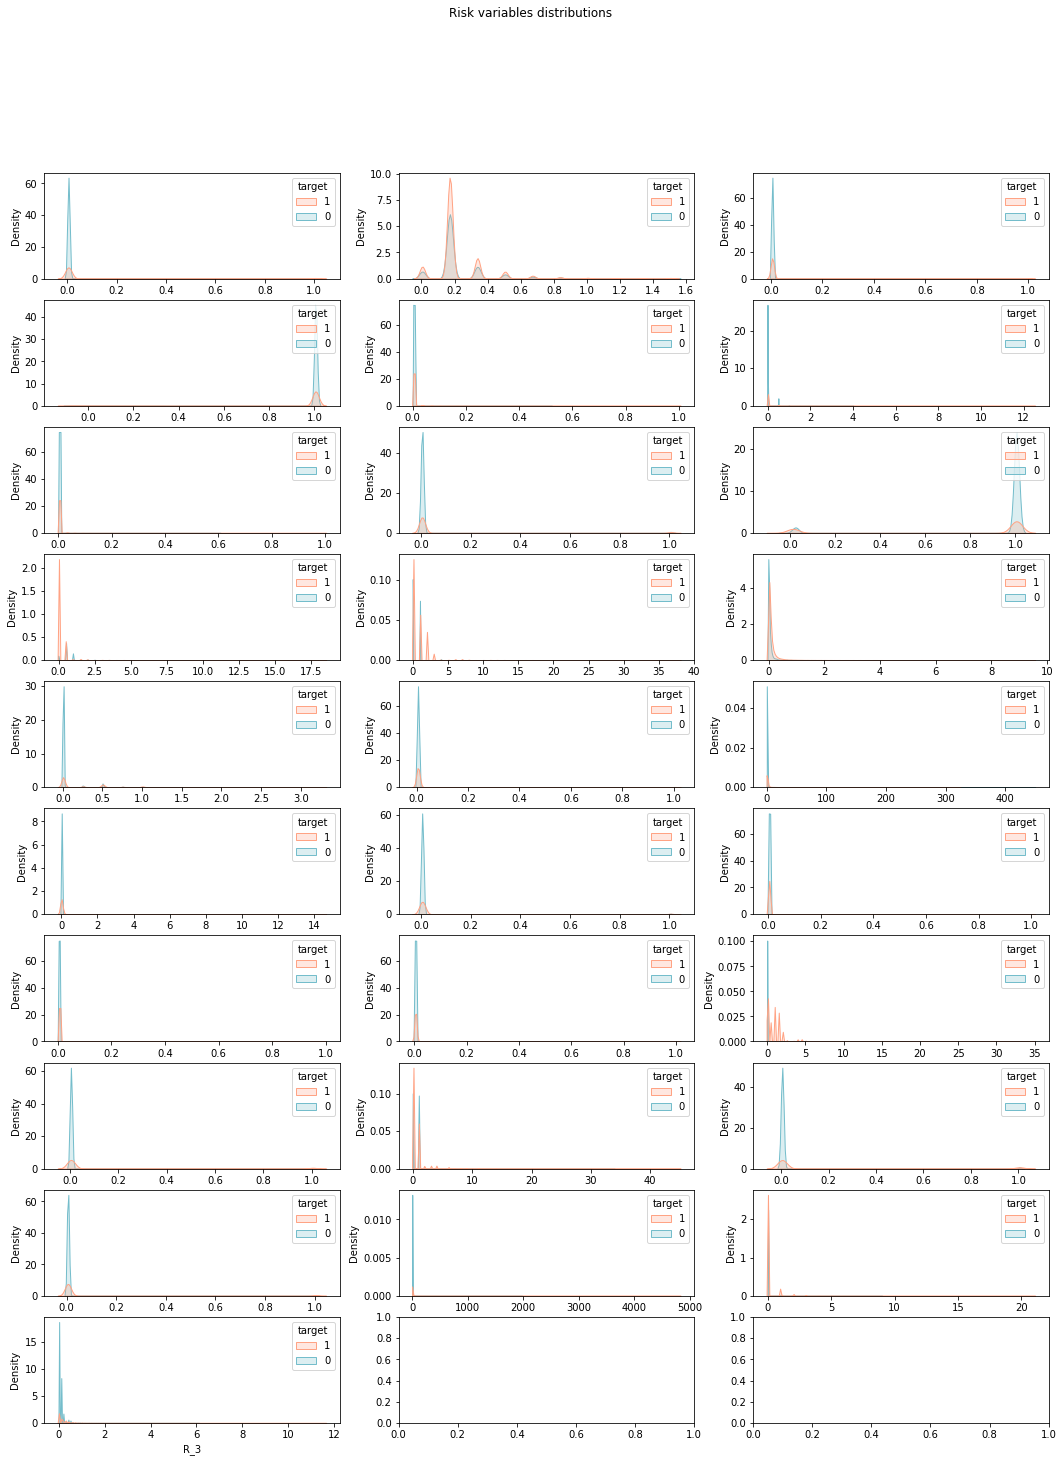

In [7]:
R_cat_features = list(set(R_features)-set(categorical_var))
nrow = 10
ncol = 3
figsize = (18, 23)
hue = 'target'
title = 'Risk variables distributions'

plot_histogram(data, R_cat_features, nrow, ncol, figsize, title, hue)

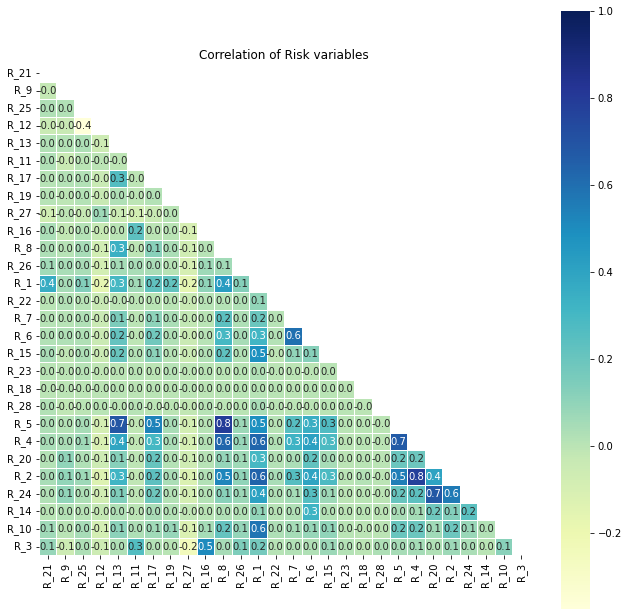

In [8]:
plot_correlation_matrix(data[R_cat_features], (11, 11), 'Correlation of Risk variables')

Generally speaking we do not have big correlation trends.</br>
What about correlation with the traget values ?

In [11]:
palette = cycle(["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"])
targ = data.corrwith(data['target'], axis=0)
val = [str(round(v ,1) *100) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of variables with Target",width = 750, height = 3500,
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)')

Except perhaps for the varibale `P_2`, we do not make out any strong correlation with the target. Thus, it would be worth keeping as many varibales as possible.

# <a name="C6">Part 3: Prediction models</a>

We can now try and compare different prediction models.</br>
But first we need a metric to comapre those models. In addition to the computation time and the accuracy score, we will use the metric given by the Amex competition, which can be found [here](https://www.kaggle.com/code/inversion/amex-competition-metric-python).

In [2]:
#Evaluation metric 
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

## <a name="C7">3.1: Data processing</a>
First, the dataset contains some categorical variables we need to encode. Second, the dataset being very large and our memory space and computation capacity limited, we will consider only 10% of it while testing different models in order to speed up the process.

In [5]:
#Get 10% of the training dataset
data_reduced = data.sample(frac=0.1)
data_reduced.drop(['customer_ID'], axis=1, inplace=True)
data_reduced.shape

(553145, 190)

Another key point we want to address is the processing of missing values. We will try 3 different approaches:
- 1. We keep the data as it is, we let the model take care of missing values
- 2. We delete all variables containing missing values
- 3. We delete the variables with more than 30% of missing values and fill the others with the mean (for numerical variabe) or most frequent (for categorical variable) value

In [6]:
data[categorical_var].isnull().sum()

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_63     0
D_64     0
D_66     0
D_68     0
S_2      0
dtype: int64

We do not have any missing value for categorical variables, we will just need to complete numerical variables with the mean value, which is always 0 because the data is normalized.

In [7]:
#Get rid of variables with NaN values
data_reduced_cleaned = data_reduced.dropna(axis=1)
print("Shape after removing all columns containing any NaN value:", data_reduced_cleaned.shape)

#Get rid of variables with more than 30% of NaN values
threshold = data_reduced.shape[0]*0.7
data_reduced_processed = data_reduced.dropna(axis=1, thresh=threshold)

for var in data_reduced_processed.columns:
    if data_reduced_processed[var].isnull().sum()>0:
        data_reduced_processed[var].fillna(0, inplace=True) #data is normalized, mean=0
        
print("Shape after processing part of NaN values:", data_reduced_processed.shape)

Shape after removing all columns containing any NaN value: (553145, 80)


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Shape after processing part of NaN values: (553145, 159)


In [8]:
#Encode categorical variables
data_reduced = pd.get_dummies(data=data_reduced, columns=categorical_var, dummy_na=True)
data_reduced_cleaned = pd.get_dummies(data=data_reduced_cleaned, columns=categorical_var)
data_reduced_processed = pd.get_dummies(data=data_reduced_processed, columns=categorical_var)

print("Data shape with NaN values:", data_reduced.shape)
print("Data shape without NaN values:", data_reduced_cleaned.shape)
print("Data shape with NaN values processed:", data_reduced_processed.shape)

Data shape with NaN values: (553145, 639)
Data shape without NaN values: (553145, 517)
Data shape with NaN values processed: (553145, 596)


In [9]:
#Train/test split
X = data_reduced.drop(['target'], axis=1)
y = data_reduced['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking split 
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (442516, 638)
y_train shape: (442516,)
X_test shape: (110629, 638)
y_test shape: (110629,)


We will save training data to be sure we compare models trained on the same data.

In [ ]:
X_train.to_csv('X_train')
X_test.to_csv('X_test')
y_train.to_csv('y_train')
y_test.to_csv('y_test')

In [10]:
#Train/test split
X = data_reduced_cleaned.drop(['target'], axis=1)
y = data_reduced_cleaned['target']

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking split 
print('X_train shape:', X_train_cleaned.shape)
print('y_train shape:', y_train_cleaned.shape)
print('X_test shape:', X_test_cleaned.shape)
print('y_test shape:', y_test_cleaned.shape)

X_train shape: (442516, 516)
y_train shape: (442516,)
X_test shape: (110629, 516)
y_test shape: (110629,)


In [ ]:
X_train_cleaned.to_csv('X_train_cleaned')
X_test_cleaned.to_csv('X_test_cleaned')
y_train_cleaned.to_csv('y_train_cleaned')
y_test_cleaned.to_csv('y_test_cleaned')

In [11]:
#Train/test split
X = data_reduced_processed.drop(['target'], axis=1)
y = data_reduced_processed['target']

X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(X, y, test_size=0.2, 
                                                                                            random_state=42)

# Checking split 
print('X_train shape:', X_train_processed.shape)
print('y_train shape:', y_train_processed.shape)
print('X_test shape:', X_test_processed.shape)
print('y_test shape:', y_test_processed.shape)

X_train shape: (442516, 595)
y_train shape: (442516,)
X_test shape: (110629, 595)
y_test shape: (110629,)


In [ ]:
X_train_processed.to_csv('X_train_processed')
X_test_processed.to_csv('X_test_processed')
y_train_processed.to_csv('y_train_processed')
y_test_processed.to_csv('y_test_processed')

## <a name="C8">3.2: Model testing</a>



We will use the LGBM Classifier and the CatBoost Classifier. We have chosen those models primarily because they can handle missing values by themselves.

In [10]:
#Comparison table
res_tab = pd.DataFrame(index=['computation time', 'metric score', 'accuracy score'])

#Comparison table
res_tab_cleaned = pd.DataFrame(index=['computation time', 'metric score', 'accuracy score'])

#Comparison table
res_tab_processed = pd.DataFrame(index=['computation time', 'metric score', 'accuracy score'])

### A. With original data

In [3]:
#Load data
X_train = pd.read_csv('../input/data-entrainement-amx/X_train')
X_train.drop('Unnamed: 0', axis=1, inplace=True)

X_test = pd.read_csv('../input/data-entrainement-amx/X_test')
X_test.drop('Unnamed: 0', axis=1, inplace=True)

y_train = pd.read_csv('../input/data-entrainement-amx/y_train')
y_train.drop('Unnamed: 0', axis=1, inplace=True)

y_test = pd.read_csv('../input/data-entrainement-amx/y_test')
y_test.drop('Unnamed: 0', axis=1, inplace=True)

#### 1. LGBM 

In [4]:
search_params = {'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1]}
lgbm = LGBMClassifier()

#Grid seacrh for hyperparameters
lgbmCV = GridSearchCV(estimator=lgbm, param_grid=search_params, verbose=0)
lgbmCV.fit(X_train, y_train.values.ravel())

best_lgbm = lgbmCV.best_estimator_

In [5]:
#Print best parameters
lgbmCV.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [6]:
lgbm_time = lgbmCV.cv_results_['mean_fit_time'][3]
print(lgbm_time)

80.14467859268188


In [7]:
#Prediction on test data
y_preds_lgbm = best_lgbm.predict(X_test)

y_pred_lgbm = pd.DataFrame(y_preds_lgbm, index=y_test.index, columns=['prediction'])
y_true = pd.DataFrame(y_test, index=y_test.index, columns=['target'])
M_lgbm = amex_metric(y_true, y_pred_lgbm)
print(M_lgbm)

0.5048655502073611


In [8]:
accuracy_lgbm = accuracy_score(y_true, y_preds_lgbm)
print(accuracy_lgbm)

0.8800133780473475


In [11]:
#Get results
res_tab.loc['computation time', 'LGBM'] = lgbm_time
res_tab.loc['metric score', 'LGBM'] = M_lgbm
res_tab.loc['accuracy score', 'LGBM'] = accuracy_lgbm
res_tab

,LGBM
computation time,80.144679
metric score,0.504866
accuracy score,0.880013


#### 2. CatBoost

In [12]:
search_params = {'iterations': [50, 100, 500],
                 'learning_rate': [0.01, 0.1]}
cat = CatBoostClassifier()

#Grid seacrh for hyperparameters
catCV = GridSearchCV(estimator=cat, param_grid=search_params, verbose=0)
catCV.fit(X_train, y_train.values.ravel())

best_cat = catCV.best_estimator_

0:	learn: 0.6823360	total: 370ms	remaining: 18.1s
1:	learn: 0.6716212	total: 696ms	remaining: 16.7s
2:	learn: 0.6612288	total: 1.01s	remaining: 15.9s
3:	learn: 0.6513473	total: 1.49s	remaining: 17.2s
4:	learn: 0.6407103	total: 2.12s	remaining: 19s
5:	learn: 0.6314889	total: 2.64s	remaining: 19.4s
6:	learn: 0.6231080	total: 2.92s	remaining: 17.9s
7:	learn: 0.6141644	total: 3.23s	remaining: 16.9s
8:	learn: 0.6055136	total: 3.59s	remaining: 16.3s
9:	learn: 0.5969293	total: 3.93s	remaining: 15.7s
10:	learn: 0.5891714	total: 4.26s	remaining: 15.1s
11:	learn: 0.5813361	total: 4.57s	remaining: 14.5s
12:	learn: 0.5734545	total: 4.9s	remaining: 13.9s
13:	learn: 0.5661908	total: 5.2s	remaining: 13.4s
14:	learn: 0.5594146	total: 5.73s	remaining: 13.4s
15:	learn: 0.5526463	total: 6.19s	remaining: 13.1s
16:	learn: 0.5461275	total: 6.47s	remaining: 12.6s
17:	learn: 0.5395405	total: 6.82s	remaining: 12.1s
18:	learn: 0.5330626	total: 7.16s	remaining: 11.7s
19:	learn: 0.5270657	total: 7.46s	remaining: 

In [13]:
#Print best parameters
catCV.best_params_

{'iterations': 500, 'learning_rate': 0.1}

In [14]:
cat_time = catCV.cv_results_['mean_fit_time'][5]
print(cat_time)

139.16265897750856


In [15]:
#Prediction on test data
y_preds_cat = best_cat.predict(X_test)

y_pred_cat = pd.DataFrame(y_preds_cat, index=y_test.index, columns=['prediction'])
y_true = pd.DataFrame(y_test, index=y_test.index, columns=['target'])
M_cat = amex_metric(y_true, y_pred_cat)
print(M_cat)

0.5068666848661444


In [16]:
accuracy_cat = accuracy_score(y_true, y_preds_cat)
print(accuracy_cat)

0.8804653391063826


In [17]:
#Get results
res_tab.loc['computation time', 'CatBoost'] = cat_time
res_tab.loc['metric score', 'CatBoost'] = M_cat
res_tab.loc['accuracy score', 'CatBoost'] = accuracy_cat
res_tab

,LGBM,CatBoost
computation time,80.144679,139.162659
metric score,0.504866,0.506867
accuracy score,0.880013,0.880465


### B. With cleaned data 

In [3]:
#Load data
X_train_cleaned = pd.read_csv('../input/data-entrainement-amx/X_train_cleaned')
X_train_cleaned.drop('Unnamed: 0', axis=1, inplace=True)

X_test_cleaned = pd.read_csv('../input/data-entrainement-amx/X_test_cleaned')
X_test_cleaned.drop('Unnamed: 0', axis=1, inplace=True)

y_train_cleaned = pd.read_csv('../input/data-entrainement-amx/y_train_cleaned')
y_train_cleaned.drop('Unnamed: 0', axis=1, inplace=True)

y_test_cleaned = pd.read_csv('../input/data-entrainement-amx/y_test_cleaned')
y_test_cleaned.drop('Unnamed: 0', axis=1, inplace=True)

#### 1. LGBM

In [4]:
search_params = {'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1]}
lgbm = LGBMClassifier()

#GridSearch for hyperparameters
lgbmCV = GridSearchCV(estimator=lgbm, param_grid=search_params, verbose=0)
lgbmCV.fit(X_train_cleaned, y_train_cleaned.values.ravel())

best_lgbm = lgbmCV.best_estimator_

In [5]:
#Print best parameters
lgbmCV.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [7]:
lgbm_time = lgbmCV.cv_results_['mean_fit_time'][3]
print(lgbm_time)

35.91344842910767


In [8]:
#Prediction on test data
y_preds_lgbm = best_lgbm.predict(X_test_cleaned)

y_pred_lgbm = pd.DataFrame(y_preds_lgbm, index=y_test_cleaned.index, columns=['prediction'])
y_true = pd.DataFrame(y_test_cleaned, index=y_test_cleaned.index, columns=['target'])
M_lgbm = amex_metric(y_true, y_pred_lgbm)
print(M_lgbm)

0.4608940985698556


In [9]:
accuracy_lgbm = accuracy_score(y_true, y_preds_lgbm)
print(accuracy_lgbm)

0.8639506820092381


In [12]:
#Get results
res_tab_cleaned.loc['computation time', 'LGBM'] = lgbm_time
res_tab_cleaned.loc['metric score', 'LGBM'] = M_lgbm
res_tab_cleaned.loc['accuracy score', 'LGBM'] = accuracy_lgbm
res_tab_cleaned

,LGBM
computation time,35.913448
metric score,0.460894
accuracy score,0.863951


#### 2. CatBoost

In [13]:
search_params = {'iterations': [50, 100, 500],
                 'learning_rate': [0.01, 0.1]}
cat = CatBoostClassifier()

#GridSearch for hyperparameters
catCV = GridSearchCV(estimator=cat, param_grid=search_params, verbose=0)
catCV.fit(X_train_cleaned, y_train_cleaned.values.ravel())

best_cat = catCV.best_estimator_

0:	learn: 0.6830425	total: 214ms	remaining: 10.5s
1:	learn: 0.6739641	total: 346ms	remaining: 8.31s
2:	learn: 0.6645251	total: 491ms	remaining: 7.7s
3:	learn: 0.6560787	total: 614ms	remaining: 7.07s
4:	learn: 0.6476860	total: 755ms	remaining: 6.79s
5:	learn: 0.6396217	total: 893ms	remaining: 6.55s
6:	learn: 0.6317046	total: 1.03s	remaining: 6.31s
7:	learn: 0.6240395	total: 1.16s	remaining: 6.11s
8:	learn: 0.6163651	total: 1.3s	remaining: 5.95s
9:	learn: 0.6089184	total: 1.45s	remaining: 5.8s
10:	learn: 0.6015129	total: 1.59s	remaining: 5.65s
11:	learn: 0.5944671	total: 1.74s	remaining: 5.51s
12:	learn: 0.5875965	total: 1.88s	remaining: 5.36s
13:	learn: 0.5806515	total: 2.02s	remaining: 5.19s
14:	learn: 0.5747943	total: 2.15s	remaining: 5.02s
15:	learn: 0.5685373	total: 2.29s	remaining: 4.87s
16:	learn: 0.5627776	total: 2.44s	remaining: 4.74s
17:	learn: 0.5569087	total: 2.58s	remaining: 4.59s
18:	learn: 0.5516283	total: 2.72s	remaining: 4.43s
19:	learn: 0.5461128	total: 2.86s	remaining:

In [14]:
#Print best parameters
catCV.best_params_

{'iterations': 500, 'learning_rate': 0.1}

In [16]:
cat_time = catCV.cv_results_['mean_fit_time'][5]
print(cat_time)

73.5781379699707


In [17]:
#Prediction on test data
y_preds_cat = best_cat.predict(X_test_cleaned)

y_pred_cat = pd.DataFrame(y_preds_cat, index=y_test_cleaned.index, columns=['prediction'])
y_true = pd.DataFrame(y_test_cleaned, index=y_test_cleaned.index, columns=['target'])
M_cat = amex_metric(y_true, y_pred_cat)
print(M_cat)

0.46639462768916135


In [18]:
accuracy_cat = accuracy_score(y_true, y_preds_cat)
print(accuracy_cat)

0.8653879181769699


In [19]:
#Get results
res_tab_cleaned.loc['computation time', 'CatBoost'] = cat_time
res_tab_cleaned.loc['metric score', 'CatBoost'] = M_cat
res_tab_cleaned.loc['accuracy score', 'CatBoost'] = accuracy_cat
res_tab_cleaned

,LGBM,CatBoost
computation time,35.913448,73.578138
metric score,0.460894,0.466395
accuracy score,0.863951,0.865388


### C. With processed data

In [20]:
#Load data
X_train_processed = pd.read_csv('../input/data-entrainement-amx/X_train_processed')
X_train_processed.drop('Unnamed: 0', axis=1, inplace=True)

X_test_processed = pd.read_csv('../input/data-entrainement-amx/X_test_processed')
X_test_processed.drop('Unnamed: 0', axis=1, inplace=True)

y_train_processed = pd.read_csv('../input/data-entrainement-amx/y_train_processed')
y_train_processed.drop('Unnamed: 0', axis=1, inplace=True)

y_test_processed = pd.read_csv('../input/data-entrainement-amx/y_test_processed')
y_test_processed.drop('Unnamed: 0', axis=1, inplace=True)

#### 1. LGBM

In [21]:
search_params = {'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1]}
lgbm = LGBMClassifier()

#GridSearch for hyperparameters
lgbmCV = GridSearchCV(estimator=lgbm, param_grid=search_params, verbose=0)
lgbmCV.fit(X_train_processed, y_train_processed.values.ravel())

best_lgbm = lgbmCV.best_estimator_

In [22]:
#Print best parameters
lgbmCV.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [23]:
lgbm_time = lgbmCV.cv_results_['mean_fit_time'][3]
print(lgbm_time)

67.84607815742493


In [24]:
#Prediction on test data
y_preds_lgbm = best_lgbm.predict(X_test_processed)

y_pred_lgbm = pd.DataFrame(y_preds_lgbm, index=y_test_processed.index, columns=['prediction'])
y_true = pd.DataFrame(y_test_processed, index=y_test_processed.index, columns=['target'])
M_lgbm = amex_metric(y_true, y_pred_lgbm)
print(M_lgbm)

0.49581840915427655


In [25]:
accuracy_lgbm = accuracy_score(y_true, y_preds_lgbm)
print(accuracy_lgbm)

0.8773558470202207


In [26]:
#Get results
res_tab_processed.loc['computation time', 'LGBM'] = lgbm_time
res_tab_processed.loc['metric score', 'LGBM'] = M_lgbm
res_tab_processed.loc['accuracy score', 'LGBM'] = accuracy_lgbm
res_tab_processed

,LGBM
computation time,67.846078
metric score,0.495818
accuracy score,0.877356


#### 2. CatBoost

In [27]:
search_params = {'iterations': [50, 100, 500],
                 'learning_rate': [0.01, 0.1]}
cat = CatBoostClassifier()

#GridSearch for hyperparameters
catCV = GridSearchCV(estimator=cat, param_grid=search_params, verbose=0)
catCV.fit(X_train_processed, y_train_processed.values.ravel())

best_cat = catCV.best_estimator_

0:	learn: 0.6821303	total: 428ms	remaining: 21s
1:	learn: 0.6715478	total: 781ms	remaining: 18.7s
2:	learn: 0.6610239	total: 1.15s	remaining: 18s
3:	learn: 0.6511447	total: 1.52s	remaining: 17.5s
4:	learn: 0.6420193	total: 1.78s	remaining: 16s
5:	learn: 0.6324478	total: 2.05s	remaining: 15s
6:	learn: 0.6230205	total: 2.31s	remaining: 14.2s
7:	learn: 0.6139137	total: 2.59s	remaining: 13.6s
8:	learn: 0.6056123	total: 2.82s	remaining: 12.9s
9:	learn: 0.5970560	total: 3.11s	remaining: 12.5s
10:	learn: 0.5890205	total: 3.4s	remaining: 12s
11:	learn: 0.5811454	total: 3.67s	remaining: 11.6s
12:	learn: 0.5729043	total: 3.94s	remaining: 11.2s
13:	learn: 0.5657519	total: 4.2s	remaining: 10.8s
14:	learn: 0.5585793	total: 4.45s	remaining: 10.4s
15:	learn: 0.5516039	total: 4.7s	remaining: 9.99s
16:	learn: 0.5450051	total: 5s	remaining: 9.7s
17:	learn: 0.5384388	total: 5.27s	remaining: 9.38s
18:	learn: 0.5322431	total: 5.75s	remaining: 9.38s
19:	learn: 0.5263488	total: 6.25s	remaining: 9.38s
20:	lea

In [28]:
#Print best parameters
catCV.best_params_

{'iterations': 500, 'learning_rate': 0.1}

In [29]:
cat_time = catCV.cv_results_['mean_fit_time'][5]
print(cat_time)

122.34145302772522


In [31]:
#Prediction on test data
y_preds_cat = best_cat.predict(X_test_processed)

y_pred_cat = pd.DataFrame(y_preds_cat, index=y_test_processed.index, columns=['prediction'])
y_true = pd.DataFrame(y_test_processed, index=y_test_processed.index, columns=['target'])
M_cat = amex_metric(y_true, y_pred_cat)
print(M_cat)

0.5026889619010003


In [32]:
accuracy_cat = accuracy_score(y_true, y_preds_cat)
print(accuracy_cat)

0.8789467499480245


In [33]:
#Get results
res_tab_processed.loc['computation time', 'CatBoost'] = cat_time
res_tab_processed.loc['metric score', 'CatBoost'] = M_cat
res_tab_processed.loc['accuracy score', 'CatBoost'] = accuracy_cat
res_tab_processed

,LGBM,CatBoost
computation time,67.846078,122.341453
metric score,0.495818,0.502689
accuracy score,0.877356,0.878947


In each case both models give similar results, but the LGBM is almost two times faster.</br>
About the data, deleting all the variables with missing values does not seem to be the best idea since it reduces the quality of prediction. Certainly the difference is small but we used only 10% of available data. For the two other methods we obtain close results, a little bit longer for unprocessed data.</br>
We still remain convinced that the delinquency variables, which contain many missing values, can reveal small details that are very important in pointing to payment default. Even if this does not improve the general quality of the model, taking into account all the variables would perhaps make it possible to avoid certain non-repayments or fraud and thus avoid dramatic consequences given the central role of banks in our societies.

# <a name="C9">Part 4: Final model</a>

Given the previous results and our understanding of the problem, our model choice is the LGBM Classifier trained on the original data without any processing of missing values.

In [ ]:
train.drop(['customer_ID'], axis=1, inplace=True)
train = pd.get_dummies(data=train, columns=categorical_var, dummy_na=True)

In [ ]:
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=300)
lgbm.fit(train, train_labels['target'])

#Save final model
pickle.dump(lgbm, open('final_model_lgbm.pkl','wb'))

In [ ]:
#Load model
lgbm = pd.read_pickle('../input/data-entrainement-amx/final_model_lgbm.pkl')

In [ ]:
preds = lgbm.predict(test)

In [ ]:
sample_submission["prediction"] = preds
sample_submission.to_csv('final_sample_submission.csv', index=False)